### Problem Statement:

- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

- As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

- You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

    - Demographics (city, age, gender etc.)
    - Tenure information (joining date, Last Date)
    - Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


**Column Profiling:**

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

## Understanding Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Loading dataset

df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv')

In [3]:
# Setting Pandas Option to View All Columns
pd.set_option('display.max_columns', None)

# Random sampling and displaying the records
df.sample(frac=1).head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
5377,5377,04/01/19,796,32.0,0.0,C26,2,50434,11/08/15,NaN,2,2,101890,3
2502,2502,06/01/19,384,26.0,1.0,C27,1,52364,21/10/18,NaN,2,2,0,2
3249,3249,06/01/19,486,39.0,1.0,C10,0,31674,31/10/16,NaN,1,2,252270,2
13564,13564,04/01/20,2020,33.0,0.0,C3,1,58131,30/01/20,NaN,3,3,0,1
11480,11480,05/01/20,1701,32.0,1.0,C9,0,17234,19/12/19,NaN,1,1,0,1


Dropping the 'Unnamed:0' column as this is typically generated when we convert pandas dataframe to csv

In [4]:
df=df.drop(["Unnamed: 0"],axis=1)

In [5]:
def remove_outliers(data, features, method='iqr'):
    intial_shape = data.shape
    outliers = pd.DataFrame()
    if method == 'iqr':
            for f in features:
                q1 = data[f].quantile(0.25)
                q3 = data[f].quantile(0.75)
                iqr = q3-q1
                median=data[f].median()
                data[f] = np.where((data[f]<q1-1.5*iqr) | (data[f]>q3+1.5*iqr),median,data[f])
    elif method == 'z-score':
        for f in features:
            mean = data[f].mean()
            std = data[f].std()
            f_outliers = data.loc[((data[f]-mean)/std<-3) | ((data[f]-mean)/std>3)]
            outliers = outliers.append(f_outliers)
            data.drop(f_outliers.index, inplace=True)
    print(f'{outliers.shape[0]*100/intial_shape[0]}% data detected as outlier.')
    return data, outliers

In [6]:
def univariate_analysis(data, features, type_of_feature, width = 16, height =9):
    n_features = len(features)
    figsize = (width, height*n_features)
    fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize,constrained_layout=True)
    if n_features == 1:
        ax = [ax]
    if type_of_feature == 'continuous':
        for i in range(n_features):
            f = features[i]
            ax[i][0].set_title(f"Boxplot for {f}")
            sns.boxplot(y = data[f], ax=ax[i][0])
            ax[i][0].set_ylabel(f)
            sns.histplot(data[f], ax=ax[i][1], kde=True)
            ax[i][1].axvline(data[f].mean(), color='r', linestyle='--', label="Mean")
            ax[i][1].axvline(data[f].median(), color='g', linestyle='-',label="Median")
            ax[i][1].axvline(data[f].mode()[0], linestyle='--',label="Mode")
            ax[i][1].set_title(f"Histplot for {f}")
            ax[i][1].legend()
    elif type_of_feature == 'categorical':
        for i in range(n_features):
            f = features[i]
            counts = df[f].value_counts()
            ax[i][0].set_title(f"Count Plot for {f}")
            counts.plot.bar(ax=ax[i][0],color=sns.color_palette("flare"))
            ax[i][0].set_ylabel("Counts")
            ax[i][0].set_xlabel(f)
            ax[i][1].set_title(f"Pie chart for {f}")
            counts.plot.pie(autopct='%0.0f%%', ax=ax[i][1],colors=sns.color_palette("flare"))
    fig.suptitle(f"Univariate analysis of {type_of_feature} features",fontweight="bold")
    plt.show()

## Dataset Description

In [7]:
# Shape of dataset
df.shape

(19104, 13)

- Data has 19104 driver records with each record described by 13 different features

In [8]:
# Metadata 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


- Datetime features such as MMM-YY and Dateofjoining are to be converted to appropriate type

### Features conversion to appropriate types

In [9]:
# Date of Joining and MMM-YY needs to be converted to date time 

df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['YearOfReporting'] = df['MMM-YY'].dt.year
df['MonthOfReporting'] = df['MMM-YY'].dt.month

df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['YearOfJoining'] = df['Dateofjoining'].dt.year
df['MonthOfJoining'] = df['Dateofjoining'].dt.month

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   object        
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
 13  YearOfReporting 

In [11]:
# Dive deeper at driver level

df_temp= df[df['Driver_ID']==2563]

In [12]:
df_temp.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
17477,2019-01-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,484820,3,2019,1,2015,8
17478,2019-02-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,649450,3,2019,2,2015,8
17479,2019-03-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,2016920,3,2019,3,2015,8
17480,2019-04-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,347060,4,2019,4,2015,8
17481,2019-05-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,687050,4,2019,5,2015,8


**Observations:**

- There are multiple records for Unique Driver ID - 2563
- Reported in for work on the first of every month for 5 months (01/01/2019 to 05/01/19). Since the LastWorkingDate is NaN, it means the driver is still active and not churned yet. His Quaterly rating has improved from the third month onwards. His income has been steady through these 5 months.
- Clearly we have to perform some aggregation by the driver ID.

## Analyzing the Data

### Non-Graphical Analysis

In [13]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,19104.0,1415.591133,8.107053e+02,1.0,710.0,1417.0,2137.0,2788.0
Age,19043.0,34.668435,6.257912e+00,21.0,30.0,34.0,39.0,58.0
Gender,19052.0,0.418749,4.933670e-01,0.0,0.0,0.0,1.0,1.0
Education_Level,19104.0,1.021671,8.001671e-01,0.0,0.0,1.0,2.0,2.0
Income,19104.0,65652.025126,3.091452e+04,10747.0,42383.0,60087.0,83969.0,188418.0
Joining Designation,19104.0,1.690536,8.369837e-01,1.0,1.0,1.0,2.0,5.0
Grade,19104.0,2.252670,1.026512e+00,1.0,1.0,2.0,3.0,5.0
Total Business Value,19104.0,571662.074958,1.128312e+06,-6000000.0,0.0,250000.0,699700.0,33747720.0
Quarterly Rating,19104.0,2.008899,1.009832e+00,1.0,1.0,2.0,3.0,4.0
YearOfReporting,19104.0,2019.491834,4.999464e-01,2019.0,2019.0,2019.0,2020.0,2020.0


Observations:

1. We observe difference in counts indicating missing values in a fea columns.
2. Mean and Median for Income and Total Business Value significantly differ and indicative of outliers.

#### Duplicate check

In [14]:
df.duplicated().sum()

0

- There are no duplicates in the dataset

#### Missing Value Check

In [15]:
print(df.isna().sum()[df.isna().sum()>0].mul(100)/len(df))

Age                 0.319305
Gender              0.272194
LastWorkingDate    91.541039
dtype: float64


**Insights:**

- LastWorkingDate has significant number of outliers
- As there are multiple records for each unique Driver ID, we may address this issue after aggregating the data on Driver ID level

In [16]:
df.nunique()

MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
YearOfReporting             2
MonthOfReporting           12
YearOfJoining               8
MonthOfJoining             12
dtype: int64

**Insights:**

1. Dataset for 24 months for drivers in 29 different cities.
2. Our dataset has 19104 entries for 2381 unique drivers, this is inline with our observation above regarding the multiple records for single driver.
3. 493 drivers have churned out of the 2381 drivers.
4. 5 unique grades and 4 unique quarterly ratings for the drivers.

In [17]:
df['Education_Level'].value_counts()

1    6864
2    6327
0    5913
Name: Education_Level, dtype: int64

- Most of the people have either completed 12th standard or has graduate degree

### Graphical Analysis

In [18]:
 # We separate our feature columns into numerical and categorical sets
numerical_columns = set(df.select_dtypes(['number']).columns)
categorical_columns = list(set(df.columns) - numerical_columns)

In [19]:
numerical_columns

{'Age',
 'Driver_ID',
 'Education_Level',
 'Gender',
 'Grade',
 'Income',
 'Joining Designation',
 'MonthOfJoining',
 'MonthOfReporting',
 'Quarterly Rating',
 'Total Business Value',
 'YearOfJoining',
 'YearOfReporting'}

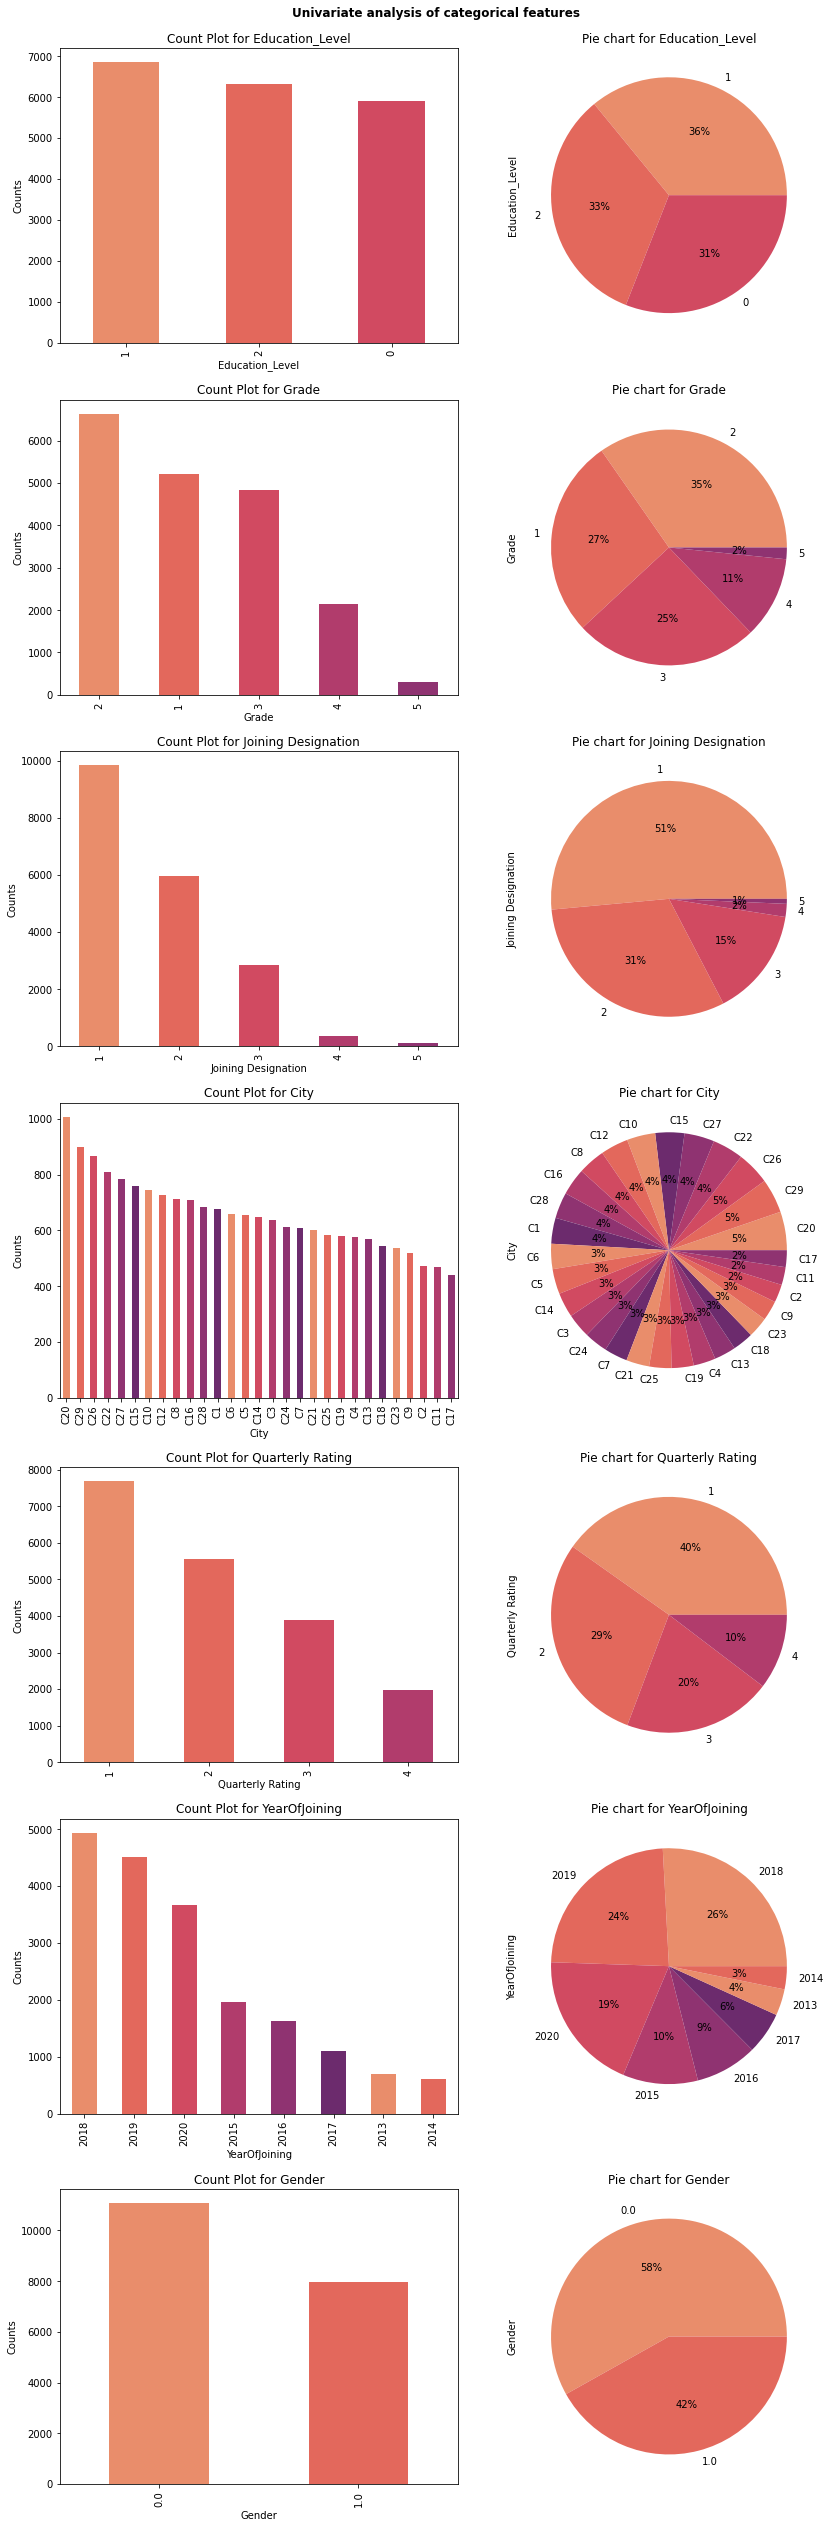

In [20]:
categorical_cols = ['Education_Level',"Grade",'Joining Designation','City',"Quarterly Rating","YearOfJoining","Gender"]

univariate_analysis(data=df, features=categorical_cols,type_of_feature='categorical', width = 12, height = 5)

**Insights:**

- City code with C20 has highest no.of employees followed by C29 and C26.
- 42% are women and 58% are men drivers.
- 26% of the drivers in our dataset joined in the year 2018-2019. The number of new joinees reduced in 2020.
- 40% of drivers have a rating of 1 and only 10% have rating of 4.
Only 3% have a joining designation of 4 or 5. 51% have a designation of 1.
- 35% of drivers fall into grade 2 and only 2% fall into a higher grade. Indicating most of the driver population is relatively recently recruited. A strong indicator of the problem of attrition.
- More or less equal distribution of drivers at each of the three Education levels= 10+,12+ and graduate.There is a possibility to offer subsidized education programs to the drivers in order to cement driver loyalty.

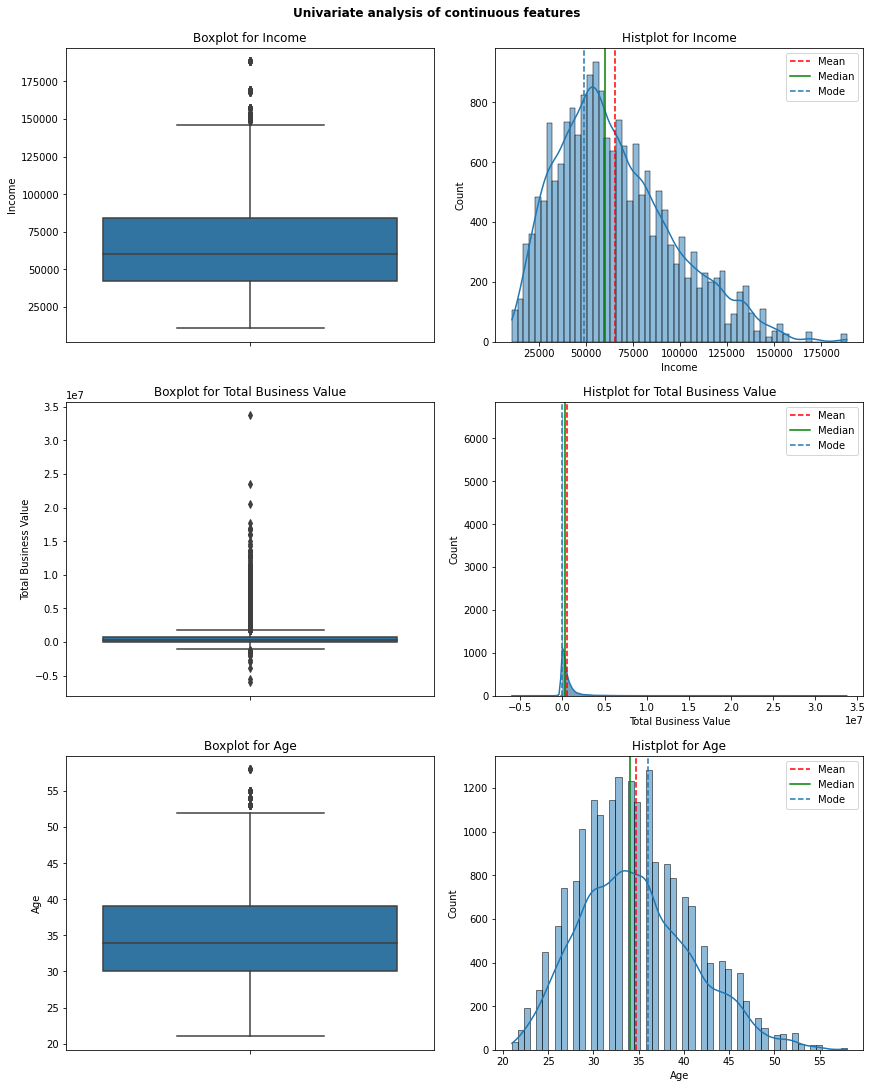

In [21]:
continuous_cols = ['Income','Total Business Value', "Age"]
univariate_analysis(data=df, features=continuous_cols,type_of_feature='continuous', width = 12, height = 5)

**Insights:**
- Driver age Distribution is normal but we observe some outliers.
- The total busines svalue is highly skewed with very high outliers indicating that a small chunk of drivers contribute to the total revenue of the company.
- Income distribution is slightly right skewed with some outliers.

## Feature Engineering

In [22]:
# Selecting numerical columns
df_nums=df.select_dtypes(np.number)

In [23]:
df_nums.isnull().sum()

Driver_ID                0
Age                     61
Gender                  52
Education_Level          0
Income                   0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
YearOfReporting          0
MonthOfReporting         0
YearOfJoining            0
MonthOfJoining           0
dtype: int64

- KNN imputation removes the column names, hence we are storing the column details, so that we can add them back after missing value imputation.


In [24]:
df_nums.drop(columns = 'Driver_ID',inplace = True)
columns = df_nums.columns

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
columns

Index(['Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating', 'YearOfReporting',
       'MonthOfReporting', 'YearOfJoining', 'MonthOfJoining'],
      dtype='object')

In [26]:
# KNN Imputation

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 3, weights = 'uniform',metric = 'nan_euclidean')
imputer.fit(df_nums)

df_new = imputer.transform(df_nums)

In [27]:
df_new = pd.DataFrame(df_new)
df_new.columns = columns 

In [28]:
df_new.isnull().sum()

Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
YearOfReporting         0
MonthOfReporting        0
YearOfJoining           0
MonthOfJoining          0
dtype: int64

- No missing values after KNN Imputation

In [29]:
# Adding the remaining columns i.e., non-number columns 

cat_cols = list(set(df.columns).difference(set(columns)))
cat_cols

['Driver_ID', 'City', 'MMM-YY', 'Dateofjoining', 'LastWorkingDate']

In [30]:
final=pd.concat([df[cat_cols],df_new],axis=1)
final.head()

,Driver_ID,City,MMM-YY,Dateofjoining,LastWorkingDate,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
0,1,C23,2019-01-01,2018-12-24,NaN,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2019.0,1.0,2018.0,12.0
1,1,C23,2019-02-01,2018-12-24,NaN,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2019.0,2.0,2018.0,12.0
2,1,C23,2019-03-01,2018-12-24,03/11/19,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019.0,3.0,2018.0,12.0
3,2,C7,2020-11-01,2020-11-06,NaN,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020.0,11.0,2020.0,11.0
4,2,C7,2020-12-01,2020-11-06,NaN,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020.0,12.0,2020.0,11.0


In [31]:
final[final['Driver_ID'] == 22]

,Driver_ID,City,MMM-YY,Dateofjoining,LastWorkingDate,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
88,22,C10,2019-01-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,216170.0,2.0,2019.0,1.0,2018.0,5.0
89,22,C10,2019-02-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,404600.0,2.0,2019.0,2.0,2018.0,5.0
90,22,C10,2019-03-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,819960.0,2.0,2019.0,3.0,2018.0,5.0
91,22,C10,2019-04-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,601680.0,4.0,2019.0,4.0,2018.0,5.0
92,22,C10,2019-05-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,635700.0,4.0,2019.0,5.0,2018.0,5.0
93,22,C10,2019-06-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,121590.0,4.0,2019.0,6.0,2018.0,5.0
94,22,C10,2019-07-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,653680.0,4.0,2019.0,7.0,2018.0,5.0
95,22,C10,2019-08-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,1120560.0,4.0,2019.0,8.0,2018.0,5.0
96,22,C10,2019-09-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,696920.0,4.0,2019.0,9.0,2018.0,5.0
97,22,C10,2019-10-01,2018-05-25,NaN,38.0,0.0,2.0,31224.0,1.0,1.0,200000.0,3.0,2019.0,10.0,2018.0,5.0


### Aggregate the records on Driver_ID

In [32]:
final.head()

,Driver_ID,City,MMM-YY,Dateofjoining,LastWorkingDate,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
0,1,C23,2019-01-01,2018-12-24,NaN,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2019.0,1.0,2018.0,12.0
1,1,C23,2019-02-01,2018-12-24,NaN,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2019.0,2.0,2018.0,12.0
2,1,C23,2019-03-01,2018-12-24,03/11/19,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019.0,3.0,2018.0,12.0
3,2,C7,2020-11-01,2020-11-06,NaN,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020.0,11.0,2020.0,11.0
4,2,C7,2020-12-01,2020-11-06,NaN,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020.0,12.0,2020.0,11.0


In [33]:
final.sort_values(by = 'Driver_ID',ascending=True)
final['Driver_ID'].unique()

array([   1,    2,    4, ..., 2786, 2787, 2788])

In [34]:
final.columns

Index(['Driver_ID', 'City', 'MMM-YY', 'Dateofjoining', 'LastWorkingDate',
       'Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating', 'YearOfReporting',
       'MonthOfReporting', 'YearOfJoining', 'MonthOfJoining'],
      dtype='object')

In [35]:
agg_dict = {'Age':'max', 'Gender':'first','City':'first',
            'Education_Level':'last', 'Income':'last',
            'Joining Designation':'last','Grade':'last',
            'Dateofjoining':'last','LastWorkingDate':'last',
            'Total Business Value':'sum','Quarterly Rating':'last',
            'YearOfReporting':'last','MonthOfReporting':'last' ,
            'YearOfJoining': "first",'MonthOfJoining':"first"}

In [36]:
df_final = final.groupby('Driver_ID').aggregate(agg_dict).reset_index()

In [37]:
df_final.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,03/11/19,1715580.0,2.0,2019.0,3.0,2018.0,12.0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,None,0.0,1.0,2020.0,12.0,2020.0,11.0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,27/04/20,350000.0,1.0,2020.0,4.0,2019.0,12.0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,03/07/19,120360.0,1.0,2019.0,3.0,2019.0,1.0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,None,1265000.0,2.0,2020.0,12.0,2020.0,7.0


In [38]:
#Lets check for a sample Driver ID 
df_final[df_final['Driver_ID'] == 22]

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
15,22,41.0,0.0,C10,2.0,31224.0,1.0,1.0,2018-05-25,26/04/20,7539490.0,1.0,2020.0,4.0,2018.0,5.0


In [39]:
final[final['Driver_ID'] == 22]

,Driver_ID,City,MMM-YY,Dateofjoining,LastWorkingDate,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining
88,22,C10,2019-01-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,216170.0,2.0,2019.0,1.0,2018.0,5.0
89,22,C10,2019-02-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,404600.0,2.0,2019.0,2.0,2018.0,5.0
90,22,C10,2019-03-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,819960.0,2.0,2019.0,3.0,2018.0,5.0
91,22,C10,2019-04-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,601680.0,4.0,2019.0,4.0,2018.0,5.0
92,22,C10,2019-05-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,635700.0,4.0,2019.0,5.0,2018.0,5.0
93,22,C10,2019-06-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,121590.0,4.0,2019.0,6.0,2018.0,5.0
94,22,C10,2019-07-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,653680.0,4.0,2019.0,7.0,2018.0,5.0
95,22,C10,2019-08-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,1120560.0,4.0,2019.0,8.0,2018.0,5.0
96,22,C10,2019-09-01,2018-05-25,NaN,40.0,0.0,2.0,31224.0,1.0,1.0,696920.0,4.0,2019.0,9.0,2018.0,5.0
97,22,C10,2019-10-01,2018-05-25,NaN,38.0,0.0,2.0,31224.0,1.0,1.0,200000.0,3.0,2019.0,10.0,2018.0,5.0


### Flags to indicate increase in Quarterly Rating

- Creating binary flags for driver rating increase. If the quarterly rating has increased for a driver, we assign the value 1 else 0.

In [40]:
# First Quarterly Rating
qr_first = final.groupby('Driver_ID').agg({'Quarterly Rating':'first'})

# Latest Quarterly Rating
qr_latest = final.groupby('Driver_ID').agg({'Quarterly Rating':'last'})

# Flag to indicate if the rating has increased or not 
qr = (qr_latest['Quarterly Rating'] > qr_first['Quarterly Rating']).reset_index()

In [41]:
# Drivers whose rating increased 
DriverID = qr[qr['Quarterly Rating'] == True]['Driver_ID']

In [42]:
rating_flag = []

for i in df_final['Driver_ID']:
  if i in DriverID:
    rating_flag.append(1)
  else:
    rating_flag.append(0)

In [43]:
df_final['Quarterly Rating Increased Flag'] = rating_flag
df_final.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining,Quarterly Rating Increased Flag
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,03/11/19,1715580.0,2.0,2019.0,3.0,2018.0,12.0,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,None,0.0,1.0,2020.0,12.0,2020.0,11.0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,27/04/20,350000.0,1.0,2020.0,4.0,2019.0,12.0,1
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,03/07/19,120360.0,1.0,2019.0,3.0,2019.0,1.0,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,None,1265000.0,2.0,2020.0,12.0,2020.0,7.0,0


### Flag to Indicate Increase in Income 

In [44]:
# First Income
income_first = final.groupby('Driver_ID').agg({'Income':'first'})

# Latest Income
income_latest = final.groupby('Driver_ID').agg({'Income':'last'})

# Flag to indicate if the rating has increased or not 
income_flag = (income_latest['Income'] > income_first['Income']).reset_index()

In [45]:
# Drivers whose Income increased 
DriverID = income_flag[income_flag['Income'] == True]['Driver_ID']

In [46]:
income_flag = []

for i in df_final['Driver_ID']:
  if i in DriverID:
    income_flag.append(1)
  else:
    income_flag.append(0)

In [47]:
df_final['Income Increased Flag'] = income_flag
df_final.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining,Quarterly Rating Increased Flag,Income Increased Flag
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,03/11/19,1715580.0,2.0,2019.0,3.0,2018.0,12.0,0,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,None,0.0,1.0,2020.0,12.0,2020.0,11.0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,27/04/20,350000.0,1.0,2020.0,4.0,2019.0,12.0,1,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,03/07/19,120360.0,1.0,2019.0,3.0,2019.0,1.0,0,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,None,1265000.0,2.0,2020.0,12.0,2020.0,7.0,0,0


### Flag to indicate Churn

Creating the target variable indicating if the driver has left the company

- If a driver has a last working date as non-null we assign a flag value of 1
- If the last working date value is null and does not have a last working date are assigned a flag value of 0.

In [48]:
lwr = (final.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isnull().reset_index())
#The employee ids who do not have last working date
empid = lwr[lwr['LastWorkingDate']==True]['Driver_ID']
target = []
for i in df_final['Driver_ID']:
    if i in empid.values:
        target.append(0)
    elif i not in empid.values:
        target.append(1)

df_final['Churn'] = target

In [49]:
df_final.Churn.value_counts()

1    1616
0     765
Name: Churn, dtype: int64

In [50]:
df_final.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,YearOfReporting,MonthOfReporting,YearOfJoining,MonthOfJoining,Quarterly Rating Increased Flag,Income Increased Flag,Churn
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,03/11/19,1715580.0,2.0,2019.0,3.0,2018.0,12.0,0,0,1
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,None,0.0,1.0,2020.0,12.0,2020.0,11.0,0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,27/04/20,350000.0,1.0,2020.0,4.0,2019.0,12.0,1,0,1
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,03/07/19,120360.0,1.0,2019.0,3.0,2019.0,1.0,0,0,1
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,None,1265000.0,2.0,2020.0,12.0,2020.0,7.0,0,0,0


### Summary of dataframe after Feature Engineering

In [51]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.376354e+01,5.946568e+00,21.0,30.0,33.0,37.0,58.0
Gender,2381.0,4.108918e-01,4.917194e-01,0.0,0.0,0.0,1.0,1.0
Education_Level,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total Business Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Quarterly Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0
YearOfReporting,2381.0,2.019651e+03,4.766249e-01,2019.0,2019.0,2020.0,2020.0,2020.0


**Insights:**

- Total Unique Drivers are 2381
- Mean Age of Drivers is 33yrs, with minimum of 21yrs and maximum of 58yrs
- Mean Monthly Income is 59334 and 50% of Drivers have income <= 55315
- Average Business Value generated per Driver is 4,586,742 and 75% of Drivers has generated Business Value <= 4173650

In [52]:
# Target variable 

df_final.Churn.value_counts()

1    1616
0     765
Name: Churn, dtype: int64

In [53]:
df_final.Churn.value_counts(normalize = True)*100

1    67.870643
0    32.129357
Name: Churn, dtype: float64

- Almost 67.8% of Drivers has left the company

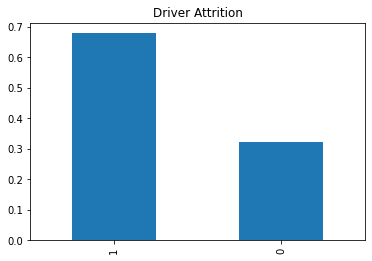

In [54]:
df_final['Churn'].value_counts(normalize=True).plot.bar(title='Driver Attrition')

### Bivariate Analysis
``` Now that we have extracted enough features and also created the target variable. Let's Analyze how target relates with other features```

#### Age vs Churn 

In [55]:
# Age is a continuous variable, so lets create few buckets for age, for which need to find min and max values, which are 21 and 58

bins = [20,30,40,50,60]
df_final['Age_Bucket'] = pd.cut(df_final['Age'],bins = bins)
df_final[['Age','Age_Bucket']].head()

,Age,Age_Bucket
0,28.0,"(20, 30]"
1,31.0,"(30, 40]"
2,43.0,"(40, 50]"
3,29.0,"(20, 30]"
4,31.0,"(30, 40]"


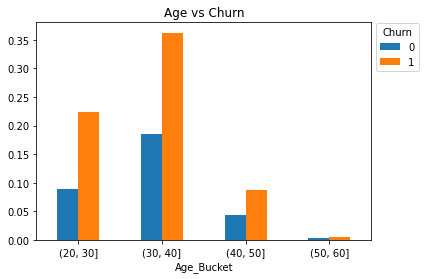

In [56]:
ct = pd.crosstab(df_final['Age_Bucket'],df_final['Churn'],normalize=True)

ax = ct.plot(kind='bar', stacked=False, rot=0)
ax.set_title('Age vs Churn')
ax.legend(title='Churn', bbox_to_anchor=(1, 1.02), loc='upper left')

**Insights:**

- Churn rate is found highest in people of age (30,40], followed by (20,30]
- Interesting thing is, the above trend is followed in non-churn categories too
- least Churn rate is observed in (50,60] age group

#### Education_level vs Churn

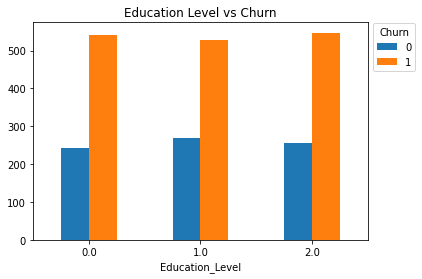

In [57]:
ct = pd.crosstab(df_final['Education_Level'],df_final['Churn'])

ax = ct.plot(kind='bar', stacked=False, rot=0)
ax.set_title('Education Level vs Churn')
ax.legend(title='Churn', bbox_to_anchor=(1, 1.02), loc='upper left')

- Churn Rate is almost similar in people of all education levels. However People of Level-2 have a bit higher churn rate compared to others. 
- Same trend is observed among those who doesn't churn

#### City vs Churn

<Figure size 2160x504 with 0 Axes>

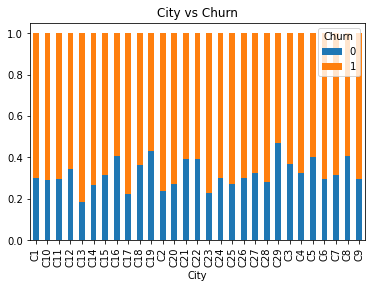

In [58]:
plt.figure(figsize=(30,7))
city = pd.crosstab(df_final['City'],df_final['Churn'])
city.div(city.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="City vs Churn")

- Maximum percentage of churn is in C13 city followed by C17 and C2.
- No clear pattern derived from the city information.

#### Income vs Churn Relationship

In [59]:
df_final.Income.describe().T

count      2381.000000
mean      59334.157077
std       28383.666384
min       10747.000000
25%       39104.000000
50%       55315.000000
75%       75986.000000
max      188418.000000
Name: Income, dtype: float64

In [60]:
# Min and Max value of Income are approximately apart by 180K, which can be divided into 6 bins of 30K width 

bins = [10000,40000,70000,100000,130000,160000,190000]
df_final['Income_Bucket'] = pd.cut(df_final['Income'],bins = bins)
df_final[['Income','Income_Bucket']].head()

,Income,Income_Bucket
0,57387.0,"(40000, 70000]"
1,67016.0,"(40000, 70000]"
2,65603.0,"(40000, 70000]"
3,46368.0,"(40000, 70000]"
4,78728.0,"(70000, 100000]"


<Figure size 1080x576 with 0 Axes>

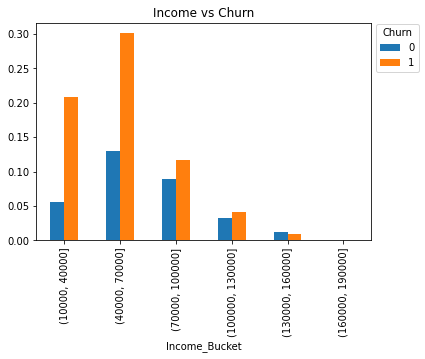

In [61]:
ct = pd.crosstab(df_final['Income_Bucket'],df_final['Churn'],normalize=True)
plt.figure(figsize=(15,8))
ax = ct.plot(kind='bar', stacked=False, rot=90)
ax.set_title('Income vs Churn')
ax.legend(title='Churn', bbox_to_anchor=(1, 1.02), loc='upper left')

- Drivers with lower income are more likely to churn.
- Churn is same across income brackets of 70K-100K and 100K-130K.
- The employees whose monthly income is in 130K-160K and 160K-190K are less likely to leave the organization

#### Total Business Value vs Churn

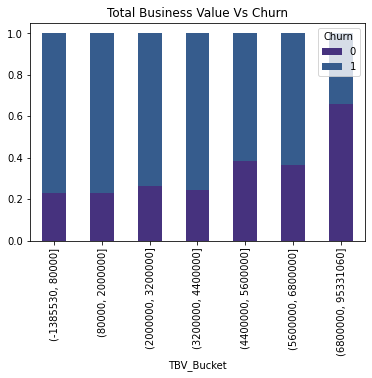

In [62]:
#Defining the bins and groups

m1 = round(df_final['Total Business Value'].min())
m2 = round(df_final['Total Business Value'].max())
bins = [m1, 80000 , 2000000 , 3200000, 4400000, 5600000, 6800000, m2]

#Binning the Total Business Value into categories
df_final['TBV_Bucket'] = pd.cut(df_final['Total Business Value'],bins)

#Total Business Value feature with Target
tbvbin = pd.crosstab(df_final['TBV_Bucket'],df_final['Churn'])
tbvbin.div(tbvbin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Total Business Value Vs Churn",color=sns.color_palette("viridis"))


- Driver with total business value equal and above 6800,000 are less likely to churn compared to any other bracket


### Multivariate Analysis

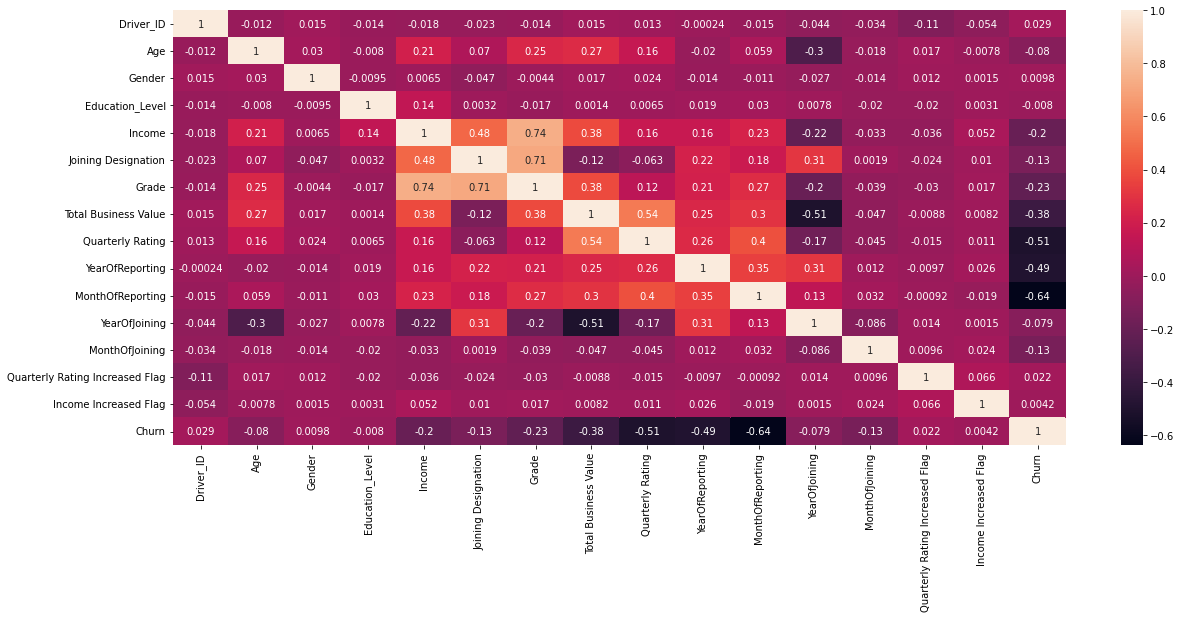

In [63]:
plt.figure(figsize=(20,8))
sns.heatmap(df_final.corr(), annot=True) 
plt.show()

- The following are positively correlated

    - Age and Income
    - Joining designation and grade
    - Total business value and grade and income. If the grade is high then the driver has a higher income and the probability of attrition is low.
    - Year of joining and Total Business are negatively correlated, indicating the longer a driver has been associated with the company the business acquired by him reduces. This needs to be investigated.
    - Quarterly rating and Total Business Value are positively correlated. Meaning if the quarterly rating is high then total business acquired is also high and consequently less chance of driver attrition.

- High Negative correlation between Churn and month of reporting,Year of Reporting. This indicates that drivers who are not regular in reporting every month have a high chance of attrition.

## Data Preprocessing for Model Creation

In [64]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Driver_ID                        2381 non-null   int64         
 1   Age                              2381 non-null   float64       
 2   Gender                           2381 non-null   float64       
 3   City                             2381 non-null   object        
 4   Education_Level                  2381 non-null   float64       
 5   Income                           2381 non-null   float64       
 6   Joining Designation              2381 non-null   float64       
 7   Grade                            2381 non-null   float64       
 8   Dateofjoining                    2381 non-null   datetime64[ns]
 9   LastWorkingDate                  1616 non-null   object        
 10  Total Business Value             2381 non-null   float64    

In [65]:
# Dropping few unwanted columns

df_final.drop(["Age_Bucket","Income_Bucket","TBV_Bucket",'Driver_ID', 
               'Dateofjoining', 'LastWorkingDate',"YearOfReporting","MonthOfJoining"]
,axis=1, inplace=True)

In [66]:
df_final.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,MonthOfReporting,YearOfJoining,Quarterly Rating Increased Flag,Income Increased Flag,Churn
0,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,3.0,2018.0,0,0,1
1,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,12.0,2020.0,0,0,0
2,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,4.0,2019.0,1,0,1
3,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,3.0,2019.0,0,0,1
4,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,12.0,2020.0,0,0,0


In [67]:
# Checking for feature with non-numerical values:
from pandas.api.types import is_numeric_dtype
company_col = list(df_final.columns)
for col in company_col:
    if is_numeric_dtype(df_final[col])== False:
        print(col)

City


In [68]:
df_final.Gender.value_counts()

0.000000    1401
1.000000     976
0.666667       3
0.333333       1
Name: Gender, dtype: int64

In [69]:
df_final['Gender'] = df_final['Gender'].apply(lambda x: 1 if x > 0.9 else 0)
df_final.Gender.value_counts()

0    1405
1     976
Name: Gender, dtype: int64

In [70]:
df_final['Education_Level'].value_counts()

2.0    802
1.0    795
0.0    784
Name: Education_Level, dtype: int64

In [71]:
X = df_final.drop(["Churn"],axis =1)
y = df_final['Churn']

In [72]:
# Train, CV, test split
from sklearn.model_selection import train_test_split
#0.6, 0.2, 0.2 split

X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.2, random_state=42)

In [73]:
print("Number of records X_train dataset: ", X_train.shape)
print("Number of records y_train dataset: ", y_train.shape)
print("Number of records X_CV dataset: ", X_val.shape)
print("Number of records y_CV dataset: ", y_val.shape)
print("Number of records X_test dataset: ", X_test.shape)
print("Number of records y_test dataset: ", y_test.shape)

Number of records X_train dataset:  (1523, 13)
Number of records y_train dataset:  (1523,)
Number of records X_CV dataset:  (381, 13)
Number of records y_CV dataset:  (381,)
Number of records X_test dataset:  (477, 13)
Number of records y_test dataset:  (477,)


In [74]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()
X_train['City'] = encoder.fit_transform(X_train['City'], y_train)

In [76]:
#Converting city from category to numerical via target encoding for cv data:

X_val['City'] = encoder.transform(X_val['City'], y_val)

In [77]:
X_test['City'] = encoder.transform(X_test['City'], y_test)

In [78]:
X_train

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,MonthOfReporting,YearOfJoining,Quarterly Rating Increased Flag,Income Increased Flag
160,34.0,0,0.671881,1.0,20922.0,2.0,2.0,151600.0,1.0,3.0,2019.0,0,0
1643,37.0,0,0.494747,1.0,67317.0,1.0,2.0,1061950.0,1.0,10.0,2016.0,0,0
1159,43.0,1,0.643642,1.0,87325.0,3.0,3.0,566440.0,1.0,8.0,2020.0,0,0
499,30.0,1,0.613089,2.0,70570.0,1.0,2.0,1583300.0,1.0,7.0,2017.0,0,0
1214,33.0,1,0.680316,1.0,70900.0,1.0,1.0,1741830.0,1.0,6.0,2018.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,34.0,0,0.634724,0.0,82815.0,2.0,3.0,21748820.0,4.0,12.0,2015.0,0,0
652,37.0,1,0.671881,1.0,18285.0,1.0,1.0,386590.0,1.0,3.0,2018.0,0,0
1943,27.0,1,0.506750,2.0,83632.0,2.0,2.0,371110.0,2.0,12.0,2020.0,0,0
1066,38.0,1,0.692755,1.0,130277.0,3.0,3.0,988020.0,1.0,1.0,2019.0,0,0


### Model 1 - Decision Trees

- Using f1_score as the data is imbalanced
- Hyper-parameter tuning with max_depth and class_weight

In [79]:
# We train a simple decision tree using 5-fold cross validation and Grid Search␣
#for best hyper-param selection
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
params = {
            "max_depth" : [3, 5, 7,9],
            "max_leaf_nodes" : [15, 20, 25,30]
         }
model1 = DecisionTreeClassifier()
clf = GridSearchCV(model1, params, scoring = "f1", cv=5) # as the data is imbalanced, we will use f1 score
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_leaf_nodes': [15, 20, 25, 30]},
             scoring='f1')

In [80]:
res = clf.cv_results_
for i in range(len(res["params"])):
    print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")


Parameters:{'max_depth': 3, 'max_leaf_nodes': 15} Mean_score: 0.9565102404323399 Rank: 15
Parameters:{'max_depth': 3, 'max_leaf_nodes': 20} Mean_score: 0.9565102404323399 Rank: 15
Parameters:{'max_depth': 3, 'max_leaf_nodes': 25} Mean_score: 0.9570211804152272 Rank: 13
Parameters:{'max_depth': 3, 'max_leaf_nodes': 30} Mean_score: 0.9570211804152272 Rank: 13
Parameters:{'max_depth': 5, 'max_leaf_nodes': 15} Mean_score: 0.9609199240545883 Rank: 4
Parameters:{'max_depth': 5, 'max_leaf_nodes': 20} Mean_score: 0.9608197971762408 Rank: 5
Parameters:{'max_depth': 5, 'max_leaf_nodes': 25} Mean_score: 0.9598617017804179 Rank: 9
Parameters:{'max_depth': 5, 'max_leaf_nodes': 30} Mean_score: 0.9613549809520279 Rank: 2
Parameters:{'max_depth': 7, 'max_leaf_nodes': 15} Mean_score: 0.9606865614350856 Rank: 6
Parameters:{'max_depth': 7, 'max_leaf_nodes': 20} Mean_score: 0.9574098461555666 Rank: 11
Parameters:{'max_depth': 7, 'max_leaf_nodes': 25} Mean_score: 0.960950494314368 Rank: 3
Parameters:{'max_

In [81]:
print(clf.best_estimator_)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(clf)

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=30)
Best parameters are : {'max_depth': 9, 'max_leaf_nodes': 30}
The score is : 0.9615848572222777


In [82]:
## Training the MODEL using the best hyperparameters
model1 = clf.best_estimator_
model1 = clf.best_estimator_
model1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=30)

In [83]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, Y, title):

    train_sizes, train_scores, test_scores, _ , _ = learning_curve(estimator,X,Y,return_times=True)

    fig, axes = plt.subplots(1, 1, figsize = (10, 5))

    axes.set_title(title)
    axes.plot
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
  )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="b",
  )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
  )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score"
  )
    axes.legend(loc="best")

    plt.show()

Model Performance Metrics


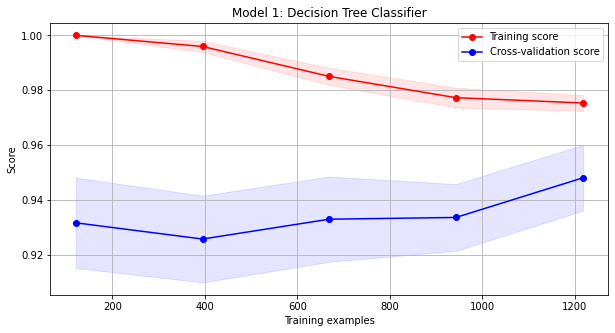

              precision    recall  f1-score   support

    Churn:0        0.92      0.89      0.91       150
     Churn:1       0.95      0.96      0.96       327

    accuracy                           0.94       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477

Test Accuracy : 94.12997903563941%
recall_score : 96.3302752293578%
precision_score : 95.16616314199395%
f1_score : 95.74468085106382%
Model 1: Decision Tree Classifier Sensitivity:0.96
Model 1: Decision Tree Classifier Specificity:0.89


In [84]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
 accuracy_score, confusion_matrix, classification_report,
 roc_auc_score, roc_curve, auc,recall_score,precision_score,f1_score, plot_confusion_matrix, plot_roc_curve
)

print("Model Performance Metrics")
plot_learning_curve(model1, X_train, y_train, "Model 1: Decision Tree Classifier")
Y_pred_model1 = model1.predict(X_test)
print(f"{classification_report(y_test, Y_pred_model1, target_names=['Churn:0 ','Churn:1'])}")


print(f"Test Accuracy : {accuracy_score(y_test, Y_pred_model1)*100}%")
print(f"recall_score : {recall_score(y_test, Y_pred_model1)*100}%")
print(f"precision_score : {precision_score(y_test, Y_pred_model1)*100}%")
print(f"f1_score : {f1_score(y_test, Y_pred_model1)*100}%")


confusion = confusion_matrix(y_test, Y_pred_model1)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
print(f"Model 1: Decision Tree Classifier Sensitivity:{np.round(TP/(TP+FN),2)}")

# Calculate the specificity
print(f"Model 1: Decision Tree Classifier Specificity:{np.round(TN/(TN+FP),2)}")

#### AUC vs ROC Curve

AUC SCORE :0.9088583078491336


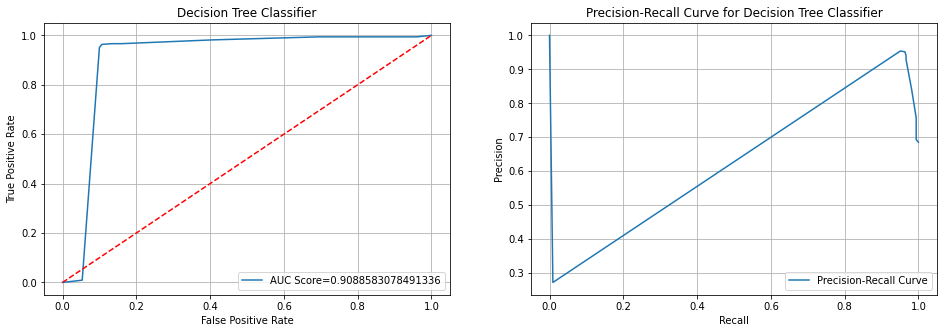

In [85]:
# AUC- ROC

Y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(y_test, Y_pred_proba)

#Create ROC curve and PR curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("Decision Tree Classifier")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for Decision Tree Classifier")
plt.show()

#### Visualize the Decision Tree

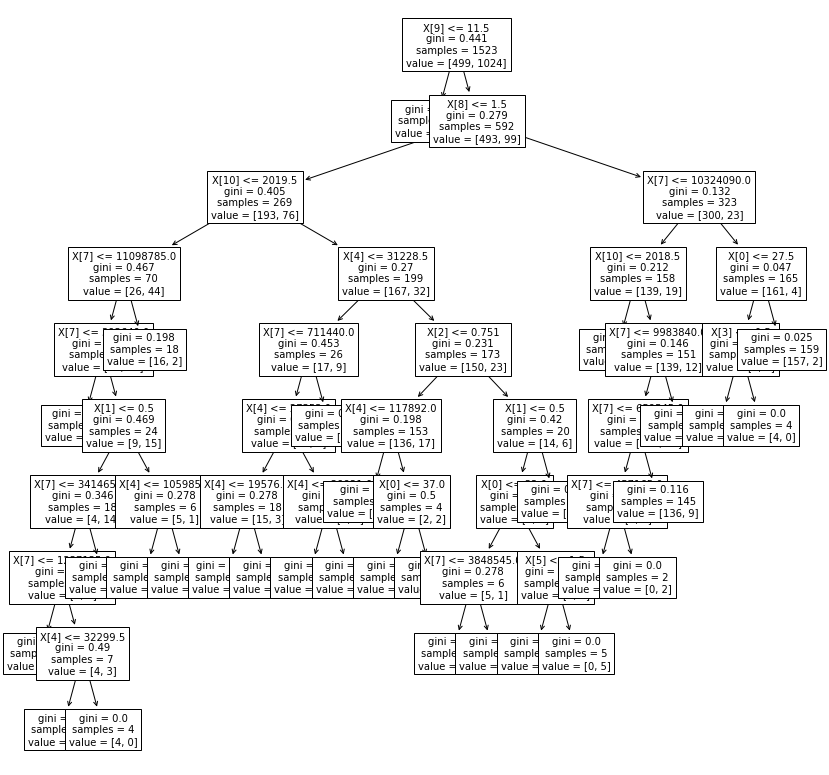

In [86]:
# plot the decision tree
from sklearn import tree
plt.figure(figsize=(14,14))  # set plot size (denoted in inches)
tree.plot_tree(model1, fontsize=10)
plt.show()

#### Feature Importances

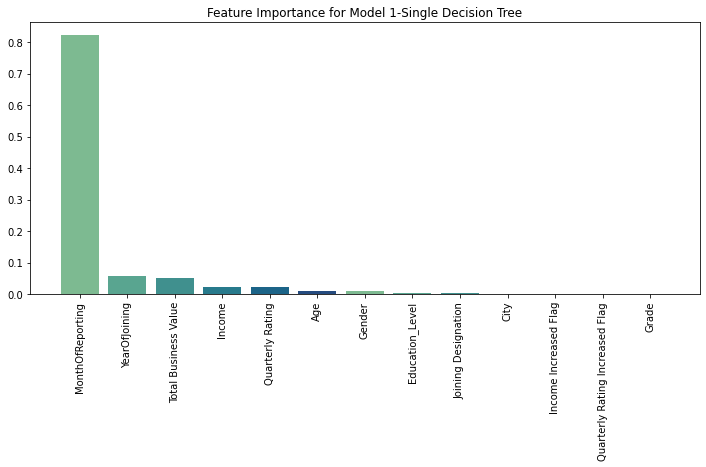

In [87]:
importances = model1.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(12, 5))
plt.title("Feature Importance for Model 1-Single Decision Tree") 
plt.bar(range(X_test.shape[1]), importances[indices],color = sns.color_palette('crest')) 
plt.xticks(range(X_test.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() 

**Insights -**

Observations from Model 1- Decision Tree Classifier:

- Best Hyperparameters are max_depth=5, max_leaf_nodes=15
- The f1 score for predicting leaving the company is 0.96
- The recall score for predicting leaving the company is 0.9663
- The precision score for predicting leaving the company is 0.9546
- The AUC score for predicting leaving the company is 0.9452
- Model Sensitivity:0.97
- Model Specificity:0.89
- The most important features according to model 1:
    - Month of Reporting
    - Year of joining
    - Total Business Value
    - Quarterly Rating
    - Education_level
    - Income 

## Model - 2: Random Forest Classifier

- Hyperparameters: max_depth, Number of Estimators (using GridSearch CV)
- Metric: F1 score as the data is imbalanced
- Balance the class weights using class_weight

In [88]:
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix

param = { 'max_depth' : [2,3,4,5],
          'n_estimators' : [50,100,150,200] 
        }
RandomForest = RandomForestClassifier(class_weight = 'balanced')

c = GridSearchCV(RandomForest,param,cv = 5, scoring = 'f1')
c.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [89]:
print(f'Best Parameters: {c.best_params_}')
print(f'Score: {c.best_score_}')

Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Score: 0.9566483298205151


In [90]:
res = c.cv_results_

for i in range(len(res["params"])):
    print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'max_depth': 2, 'n_estimators': 50} Mean_score: 0.9511801229224405 Rank: 9
Parameters:{'max_depth': 2, 'n_estimators': 100} Mean_score: 0.9484604316314064 Rank: 12
Parameters:{'max_depth': 2, 'n_estimators': 150} Mean_score: 0.9480318960652785 Rank: 13
Parameters:{'max_depth': 2, 'n_estimators': 200} Mean_score: 0.9467983487295341 Rank: 16
Parameters:{'max_depth': 3, 'n_estimators': 50} Mean_score: 0.947365742661218 Rank: 14
Parameters:{'max_depth': 3, 'n_estimators': 100} Mean_score: 0.951116743960832 Rank: 10
Parameters:{'max_depth': 3, 'n_estimators': 150} Mean_score: 0.947341639748006 Rank: 15
Parameters:{'max_depth': 3, 'n_estimators': 200} Mean_score: 0.9505845336901938 Rank: 11
Parameters:{'max_depth': 4, 'n_estimators': 50} Mean_score: 0.9549154485449314 Rank: 5
Parameters:{'max_depth': 4, 'n_estimators': 100} Mean_score: 0.9526968444809569 Rank: 7
Parameters:{'max_depth': 4, 'n_estimators': 150} Mean_score: 0.9532951472072035 Rank: 6
Parameters:{'max_depth': 4, 'n_

In [91]:
print(c.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50)


In [92]:
random_forest=c.best_estimator_
random_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50)

 Model 2: Random Forest Classifier: Performance Report


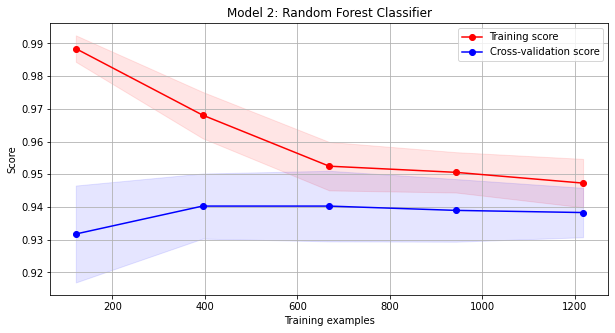

              precision    recall  f1-score   support

     Churn:0       0.90      0.95      0.92       150
     Churn:1       0.97      0.95      0.96       327

    accuracy                           0.95       477
   macro avg       0.94      0.95      0.94       477
weighted avg       0.95      0.95      0.95       477

Test Accuracy : 94.9685534591195%
recall_score : 95.10703363914374%
precision_score : 97.4921630094044%
f1_score : 96.28482972136223%
[[142   8]
 [ 16 311]]
Model 2 Sensitivity: 0.95
Model 2 Specificity: 0.95


In [93]:
print(" Model 2: Random Forest Classifier: Performance Report")

Y_pred = random_forest.predict(X_test)
plot_learning_curve(random_forest, X_train, y_train, "Model 2: Random Forest Classifier")
print(f"{classification_report(y_test, Y_pred, target_names=['Churn:0','Churn:1'])}")



print(f"Test Accuracy : {accuracy_score(y_test, Y_pred)*100}%")
print(f"recall_score : {recall_score(y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(y_test, Y_pred)*100}%")

cm = confusion_matrix(y_test, Y_pred)
print(cm)

confusion = confusion_matrix(y_test, Y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Calculate the sensitivity

print(f"Model 2 Sensitivity: {np.round((TP/(TP+FN)),2)}")
# Calculate the specificity

print(f"Model 2 Specificity: {np.round((TN/(TN+FP)),2)}")

AUC SCORE :0.9659836901121305


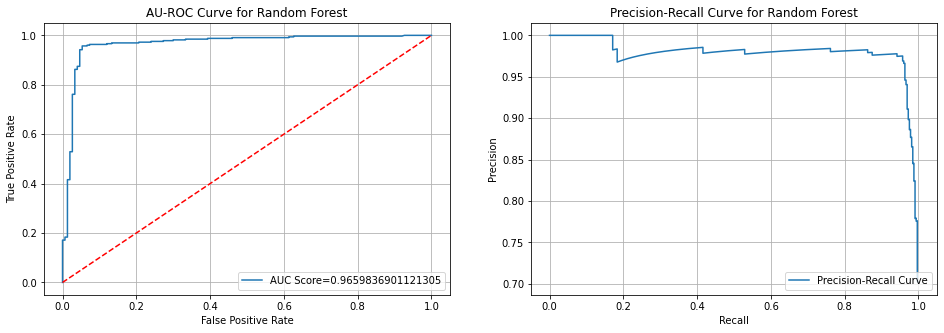

In [94]:
# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = random_forest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(y_test, Y_pred_proba)
#Create ROC curve and PR curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("AU-ROC Curve for Random Forest")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for Random Forest")
plt.show()

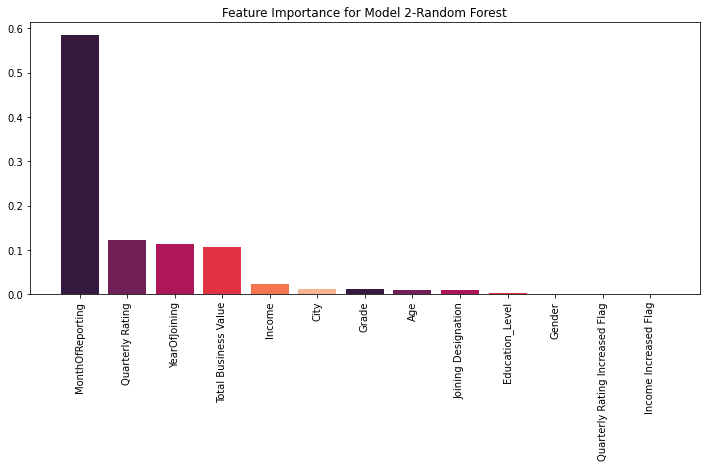

In [95]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(12, 5)) 
plt.title("Feature Importance for Model 2-Random Forest")
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("rocket")) 
plt.xticks(range(X_test.shape[1]), names, rotation=90) 
plt.show() 

**Insights -**

Observations from Random Forest Classifier:

- Best Hyperparameters are max_depth=5, n_estimators=150
- The f1 score for predicting leaving the company is 0.96
- The recall score for predicting leaving the company is 0.951
- The precision score for predicting leaving the company is 0.9749
- The AUC score for predicting leaving the company is 0.9691
- Model Sensitivity:0.95
- Model Specificity:0.95
- The most important features according to model 1:
    - Month of Reporting
    - Quarterly Rating
    - Year Of Joining
    - Total Business Value
    - Income
    - Grade 

- Summary: Model 2 with the random forest classifier has better AUC, sensitivity metric than model1 Decision Tree Classifier. Another very significant advantage is this RF model captures the feature importance more accurately. The precision -recall curve is also better for the RF model.



## Model - 3 : Gradient Boosted Decision Tree

In [96]:
from sklearn.ensemble import GradientBoostingClassifier as GBDT
params = {
        'learning_rate': [0.1,0.4, 0.6, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'max_depth': [3, 4, 5,6],
    'n_estimators':[50,100,150,200,250]
        }
model3=GBDT()

In [97]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold  
import datetime as dt

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model3, param_distributions=params, n_iter=10, scoring='f1', n_jobs=4, cv=skf.split(X_train,y_train), random_state=1001 )
start = dt.datetime.now()
random_search.fit(X_train, y_train)
end = dt.datetime.now()

In [98]:
print(f'Best hyperparameters: {random_search.best_params_}')

Best hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.6}


In [99]:
gbdt_final = GBDT(subsample=1.0, n_estimators=100, max_depth=5, learning_rate= 0.6)
gbdt_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.6, max_depth=5)

In [100]:
print(f"Time taken for training : {end - start}")
print(f"Training accuracy:{gbdt_final.score(X_train, y_train)}")
print(f"Test Accuracy:{gbdt_final.score(X_test, y_test)}")


Time taken for training : 0:00:18.478925
Training accuracy:1.0
Test Accuracy:0.9454926624737946


 Model 3: GBDT Performance Report


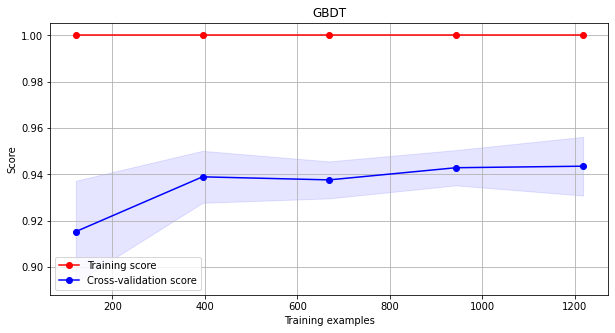

              precision    recall  f1-score   support

     Churn:0       0.91      0.91      0.91       150
    Churn:1)       0.96      0.96      0.96       327

    accuracy                           0.95       477
   macro avg       0.94      0.94      0.94       477
weighted avg       0.95      0.95      0.95       477

Test Accuracy : 94.54926624737946%
recall_score : 96.02446483180428%
precision_score : 96.02446483180428%
f1_score : 96.02446483180428%
[[137  13]
 [ 13 314]]
Model 3: GBDT Sensitivity: 0.96
Model 3: GBDT Specificity: 0.91


In [101]:
print(" Model 3: GBDT Performance Report")

# Predicting the Test set results
Y_pred = gbdt_final.predict(X_test)
plot_learning_curve(gbdt_final, X_train, y_train, "GBDT")
print(f"{classification_report(y_test, Y_pred, target_names=['Churn:0','Churn:1)'])}")
print(f"Test Accuracy : {accuracy_score(y_test, Y_pred)*100}%")
print(f"recall_score : {recall_score(y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(y_test, Y_pred)*100}%")

cm = confusion_matrix(y_test, Y_pred)
print(cm)

confusion = confusion_matrix(y_test, Y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Calculate the sensitivity

print(f"Model 3: GBDT Sensitivity: {np.round((TP/(TP+FN)),2)}")
# Calculate the specificity

print(f"Model 3: GBDT Specificity: {np.round((TN/(TN+FP)),2)}")

AUC SCORE :0.960835881753313


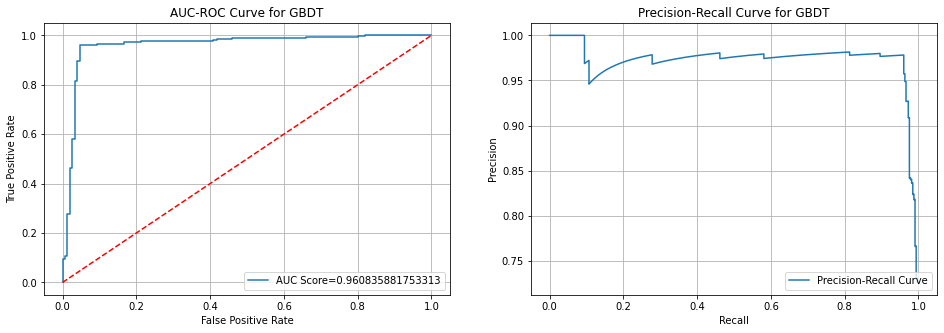

In [102]:
# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = gbdt_final.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(y_test, Y_pred_proba)
#Create ROC curve and PR curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("AUC-ROC Curve for GBDT")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for GBDT")
plt.show()

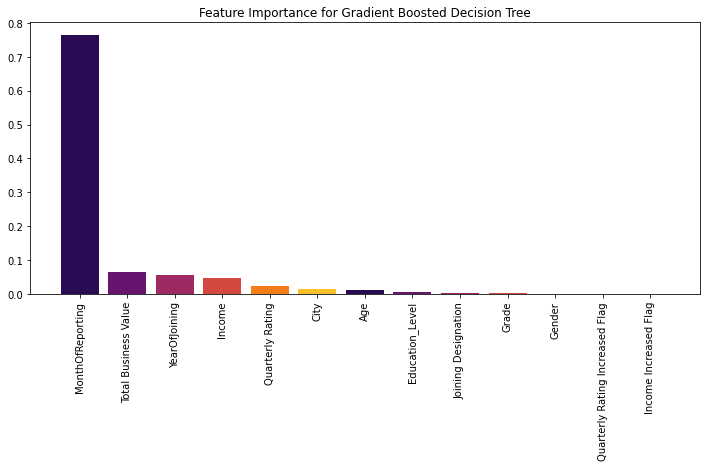

In [103]:
importances = gbdt_final.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(12, 5)) 
plt.title("Feature Importance for Gradient Boosted Decision Tree")
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("inferno")) 
plt.xticks(range(X_test.shape[1]), names, rotation=90) 
plt.show() 

**Insights -**

Observations from Gradient Boosting Decision Tree:

- Best hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.6}

- The f1 score for predicting leaving the company is 0.96
- The recall score for predicting leaving the company is 0.96
- The precision score for predicting leaving the company is 0.95
- The AUC score for predicting leaving the company is 0.96
- Model Sensitivity:0.96
- Model Specificity:0.91
- The most important features according to model 1:
    - Month of Reporting
    - Total Business Value
    - Year Of Joining
    - Income
    - Quarterly Rating
    - City

- Summary: Model 3 with the GBDT classifier has better sensitivity but less specificity compared to Model 2 Random Forest Classifier. Slightly different order of feature importances is observed with GBDT.



## Model - 4: XGBoost Classifier

In [104]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold  

import datetime as dt
params = {
        'learning_rate': [0.1, 0.4,0.6, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
    'n_estimators':[50,100,150,200,250]
        }
xgb = XGBClassifier() 

In [105]:
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='f1', n_jobs=4, cv=skf.split(X_train,y_train), random_state=1001 )

start = dt.datetime.now()
random_search.fit(X_train, y_train)
end = dt.datetime.now()

In [106]:
print(f'Best hyperparameters: {random_search.best_params_}')

Best hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [107]:
best_xgb = XGBClassifier(n_estimators=50,subsample=1.0, max_depth=5, learning_rate=0.1, colsample_bytree=0.6)
best_xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6, max_depth=5, n_estimators=50, subsample=1.0)

In [108]:
print(f"Time taken for training : {end - start}")
print(f"Training accuracy:{best_xgb.score(X_train, y_train)}")
print(f"Test Accuracy:{best_xgb.score(X_test, y_test)}")

Time taken for training : 0:00:03.788850
Training accuracy:0.9697964543663822
Test Accuracy:0.9538784067085954


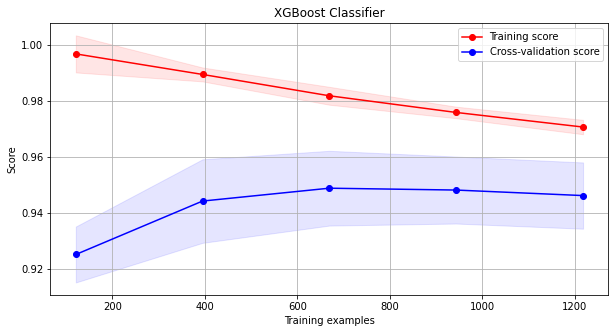

                                   precision    recall  f1-score   support

Not leaving the company (Churn:0)       0.93      0.93      0.93       150
    Leaving the company (Churn:1)       0.97      0.97      0.97       327

                         accuracy                           0.95       477
                        macro avg       0.95      0.95      0.95       477
                     weighted avg       0.95      0.95      0.95       477

Test Accuracy : 95.38784067085953%
recall_score : 96.63608562691131%
precision_score : 96.63608562691131%
f1_score : 96.63608562691131%
[[139  11]
 [ 11 316]]
Model 4: XGBoost Sensitivity: 0.97
Model 4: XGBoost Specificity: 0.93


In [109]:
# Predicting the Test set results
Y_pred = best_xgb.predict(X_test)
plot_learning_curve(best_xgb, X_train, y_train, "XGBoost Classifier")


print(f"{classification_report(y_test, Y_pred, target_names=['Not leaving the company (Churn:0)','Leaving the company (Churn:1)'])}")
print(f"Test Accuracy : {accuracy_score(y_test, Y_pred)*100}%")
print(f"recall_score : {recall_score(y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(y_test, Y_pred)*100}%")

cm = confusion_matrix(y_test, Y_pred)
print(cm)

confusion = confusion_matrix(y_test, Y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
print(f"Model 4: XGBoost Sensitivity: {np.round((TP/(TP+FN)),2)}")

# Calculate the specificity
print(f"Model 4: XGBoost Specificity: {np.round((TN/(TN+FP)),2)}")

AUC SCORE :0.9625280326197757


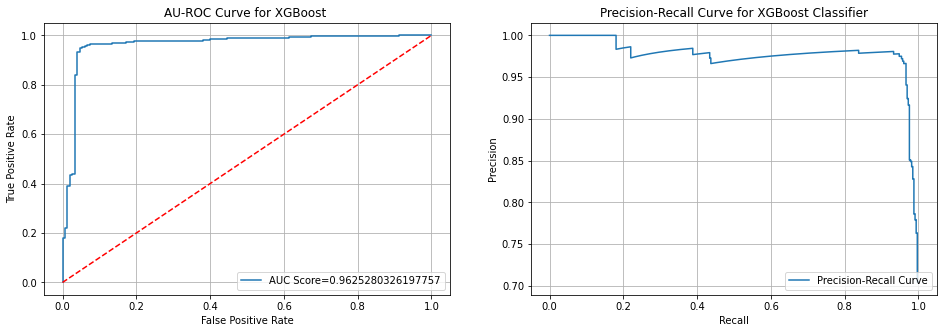

In [110]:
# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = best_xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(y_test, Y_pred_proba)

#Create ROC curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("AU-ROC Curve for XGBoost ")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for XGBoost Classifier")
plt.show()

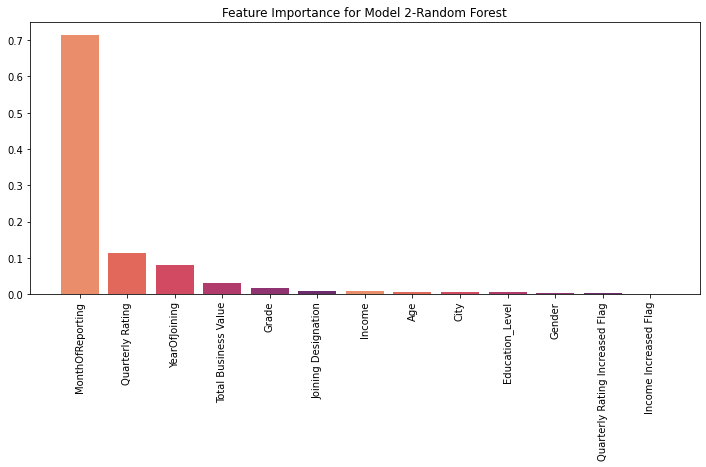

In [111]:
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(12, 5)) 
plt.title("Feature Importance for Model 2-Random Forest")
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("flare")) 
plt.xticks(range(X_test.shape[1]), names, rotation=90) 
plt.show() 

**Insights -**

Observations from XG Boost Classifier:

- Best hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}

- The f1 score for predicting leaving the company is 0.96
- The recall score for predicting leaving the company is 0.96
- The precision score for predicting leaving the company is 0.96
- The AUC score for predicting leaving the company is 0.96
- Model Sensitivity:0.97
- Model Specificity:0.93
- The most important features according to model 1:
    - Month of Reporting
    - Quarterly Rating
    - Year Of Joining
    - Total Business Value
    - Grade
    - Joining Designation

**Conclusion:**

It is a no-brainer that the cost of acquiring new drivers is at least 5X the cost of retention. In our analysis we evaluated four tree-based models and can rank them as follows based on their prediction performance metrics:

    Model4 (XGBoost) > Model3 (GBDT) > Model2 (Random Forest) > Model1 (Decision Trees)


- Using the feature importance insights generated from the models, some important predictors of driver attrition are 

    - **Month and Year of Reporting**: Drivers who actively reported into the system every month were less likely to leave. Recommendation: Company should reward such drivers with points. Company can leverage gamification based motivation strategy where drivers rank up through different levels and accumulate points for continued consistency on the system.

    - **Quarterly Performance Rating Increase**: Drivers with an increase in their quarterly rating were more likely to stay with the company. Recommendation: Company should identify the driver profile with low/high quarterly rating and extend loyalty programs that incentivizes performance improvements. Quarterly performance reviews and additional training could be imparted to the drivers whose rating has not increased over the last quarter so that issues can be identified with concerned drivers and attrition can be prevented.

    - **Total Business Value**: This is an important feature in predicting if a driver is going to leave the company or not. Recommendation: The total business value is the total business that a driver generates, the company should set small financial milestones for the drivers to work through. The company should roll out a reward and recognition program for the drivers who meet their milestones.

    - **Income/Grade**: Income plays an important role in predicting the driver attrition. Recommendation: Company should ensure that the drivers have enough opportunities and motivation to increase their monthly average income above a certain threshold. Another option to ease the financial burden on the drivers and increase their morale is to provide vehicle maintenance offers, insurance policies, health checkups, and special education programs etc.


